# Pre Start (Imports and Funcs)

In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
def latex_matrix(matrix):
    matrix_ = matrix.copy()
    text = "$\n"
    text += r"\left(\begin{matrix}" + "\n"
    for row in matrix_:
        text += " "*4 + " & ".join(map(str, row)) + r" \\" + "\n"
    text += r"\end{matrix}\right)"
    text += "\n$"
    return text

In [29]:
L = 1

def u0(x):
    return x * (x + 1)

def u2(t):
    return u0(L) * np.cos(np.pi * t)

def u(t, x):
    return u0(x) * np.cos(np.pi * t)

def F(t, x):
    return -np.cos(np.pi * t) * (np.pi**2 * x * (x + 1) + 2)

# Dots for x and t

In [30]:
x_limits = [0, L]
t_limits = [0, 5]
nx = 100
nt = 1_000_00#0

u1 = 0

x = np.linspace(*x_limits, nx)
dx = x[1] - x[0]
t = np.linspace(*t_limits, nt)
dt = t[1] - t[0]
diff = dt/ dx**2
print("dt/dx**2 = ", diff)
assert diff <= .5, f"Нестійкість! {diff}"


dt/dx**2 =  0.49005490054900547


In [31]:
dt, dx

(np.float64(5.000050000500005e-05), np.float64(0.010101010101010102))

# Main Part

$$ u(i, k+1) = 2 \cdot u(i, k) - u(i, k-1) + \Delta{t}^2 \cdot \left( \frac{u(i+1, k) - 2 \cdot u(i, k) + u(i-1, k)}{\Delta{x}^2} + F(i, k)\right) $$


$$ u(t,0) = 0 \cdot 1 \cdot \cos(\pi \cdot t) = 0 $$
$$ u(t, L) = L \cdot (L+1) \cdot \cos(\pi \cdot t) = 1 \cdot 2 \cdot \cos(\pi \cdot t) = 2 \cdot \cos(\pi \cdot t) $$

In [32]:
U = np.zeros((nt, nx), dtype=float)
U[:, 0] = u1
U[:, -1] = u2(t)
U[0, :] = u0(x)

In [38]:
for k in range(1, nx - 1):
    U[1:-1, k] = 2 * U[1:-1, k-1] - U[1:-1, k-2] + dt**2 * ((U[2:, k-1] - 2 * U[1:-1, k-1] + U[:-2, k-1]) / dx**2 + F(t[1:-1], x[k]))
print(latex_matrix(U[:10, :3]))
print(latex_matrix(U[:10, 98:]))
print(latex_matrix(U[99_997:, :3]))
print(latex_matrix(U[99_997:, 98:]))


$
\left(\begin{matrix}
    0.0 & 0.01020304050607081 & 0.020610141822263034 \\
    0.0 & -1.9999999805773505 & -3.9999507106768935 \\
    0.0 & -1.9999999065538376 & -3.9999998186151107 \\
    0.0 & -1.9999997831813179 & -3.999999571870071 \\
    0.0 & -1.999999610459795 & -3.999999226427025 \\
    0.0 & -1.9999993883892728 & -3.9999987822859797 \\
    0.0 & -1.9999991169697569 & -3.999998239446947 \\
    0.0 & -1.9999987962012535 & -3.99999759790994 \\
    0.0 & -1.999998426083771 & -3.9999968576749736 \\
    0.0 & -1.9999980066173189 & -3.9999960187420682 \\
\end{matrix}\right)
$
$
\left(\begin{matrix}
    1.9697990001020307 & 2.0 \\
    -188.43500752856792 & 1.9999999753254956 \\
    -195.91107678311408 & 1.999999901301983 \\
    -195.99956337495996 & 1.9999997779294636 \\
    -196.0000441955736 & 1.9999996052079412 \\
    -196.00002406230797 & 1.9999993831374194 \\
    -195.9999974666734 & 1.9999991117179041 \\
    -195.99996603135077 & 1.9999987909494017 \\
    -195.9999297598208 

In [34]:
# Uc = U.copy()
# for k in range(1, nx - 1):
#     for i in range(1, nt - 1):
#         Uc[i, k] = 2 * Uc[i, k-1] - Uc[i, k-2] + dt**2 * ((Uc[i+1, k-1] - 2 * Uc[i, k-1] + Uc[i-1, k-1]) / dx**2 + F(t[i], x[k]))
# (Uc == U).all()

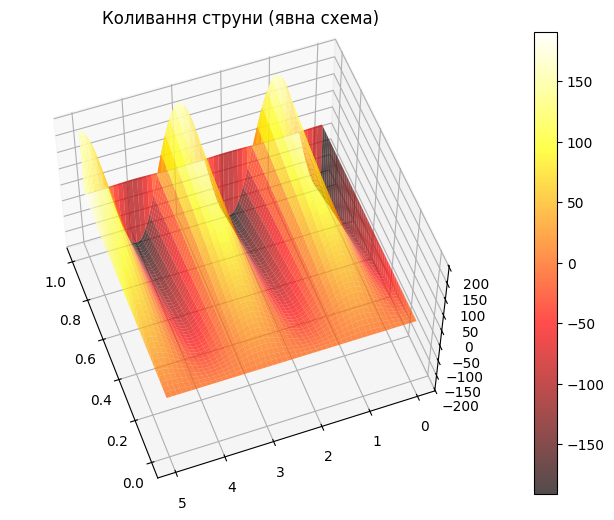

In [35]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')
x_plot, t_plot = np.meshgrid(x, t)
colorbar1 = ax1.plot_surface(x_plot, t_plot, U, cmap="hot", alpha=0.7)
fig.colorbar(colorbar1, ax=ax1, fraction=0.05, pad=0.1)

ax1.view_init(elev=55, azim=70 + 90)

ax1.set_title("Коливання струни (явна схема)")
ax1.grid(True)
plt.show()

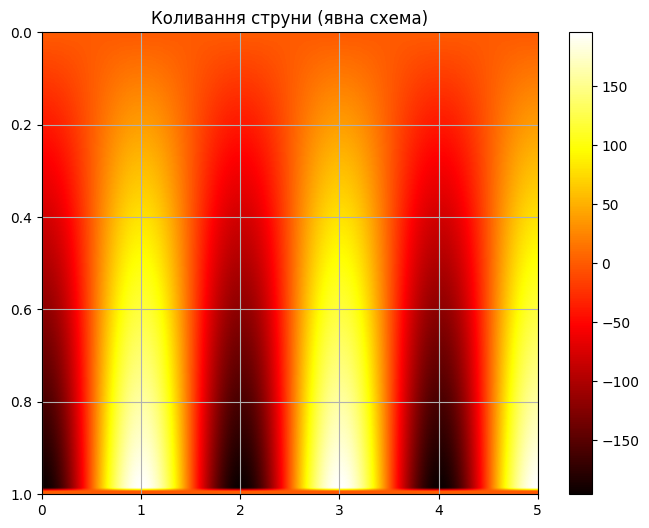

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
colorbar = ax.imshow(U[:, ::-1].T, cmap="hot", aspect="auto", extent=[t[0], t[-1], x[-1], x[0]], origin="lower")
# colorbar = ax.imshow(U, cmap="hot", aspect="auto", extent=[x[0], x[-1], t[0], t[-1]], origin="lower")
plt.colorbar(colorbar, ax=ax)

ax.set_title("Коливання струни (явна схема)")
ax.grid(True)
plt.show()

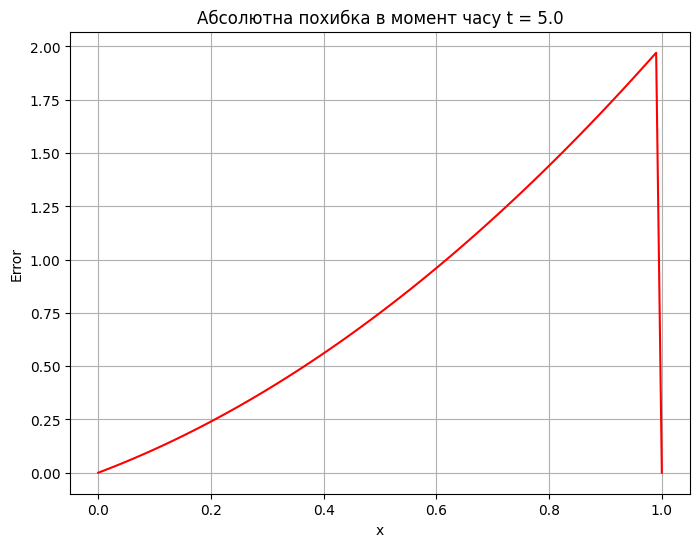

In [37]:
t_index = -1
x_plot = x[:-1]
x_plot = x
t_ = t[t_index]
U_ = U[t_index][:-1]
U_ = U[t_index]

u_exact = u(t_, x_plot)

error = np.abs(U_ - u_exact)

plt.figure(figsize=(8, 6))
plt.plot(x_plot, error, color='red')
plt.title(f"Абсолютна похибка в момент часу t = {t_}")
plt.xlabel("x")
plt.ylabel("Error")
plt.grid(True)
plt.show()
